In [45]:
symbols = ["FSPSX", "FSGGX", "FTIEX", "FSHCX", "FCPVX", "FISMX", "FGILX", "FEDDX", "FIREX", "FBCVX"]
symbols2 = [ "FNSOX", "FTBFX", "FSRBX", "SPLV"]

In [46]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

for symbol in symbols + symbols2:
    url = f"https://sg.finance.yahoo.com/quote/{symbol}/history/?period1=1638316800&period2=1732924800"

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    table = soup.find("table")

    rows = table.find_all("tr")[1:]

    data = []
    for row in rows:
        cols = row.find_all("td")
        if len(cols) < 6:
            continue
        date = cols[0].text.strip()
        open_price = cols[1].text.strip()
        high = cols[2].text.strip()
        low = cols[3].text.strip()
        close = cols[4].text.strip()
        adj_close = cols[5].text.strip()
        data.append([date, open_price, high, low, close, adj_close])

    folder = "data" if symbol not in symbols2 else "data2"
    df = pd.DataFrame(data, columns=["Date", "Open", "High", "Low", "Close", "Adj Close"])
    df.to_csv(f"./{folder}/{symbol}.csv", index=False)
    print(f"Downloaded {symbol} data")

print(df.head())


Downloaded FSPSX data
Downloaded FSGGX data
Downloaded FTIEX data
Downloaded FSHCX data
Downloaded FCPVX data
Downloaded FISMX data
Downloaded FGILX data
Downloaded FEDDX data
Downloaded FIREX data
Downloaded FBCVX data
Downloaded FNSOX data
Downloaded FTBFX data
Downloaded FSRBX data
Downloaded SPLV data
          Date   Open   High    Low  Close Adj Close
0  29 Nov 2024  74.82  75.04  74.74  74.85     74.53
1  27 Nov 2024  74.70  75.14  74.70  74.77     74.45
2  26 Nov 2024  74.27  74.61  74.08  74.56     74.24
3  25 Nov 2024  74.20  74.44  73.87  74.11     73.79
4  22 Nov 2024  73.84  74.15  73.84  73.96     73.64


In [ ]:
# 1b. Calculate monthly returns
#for symbol in symbols:
#    df = pd.read_csv(f"{symbol}.csv")
#    df["Date"] = df["Date"].str.replace("Sept", "Sep")
#    df["Date"] = pd.to_datetime(df["Date"], format="%d %b %Y", dayfirst=True)
#    df.set_index("Date", inplace=True)
#    df.sort_index(inplace=True)
#    df["Adj Close"] = df["Adj Close"].astype(float)
#    monthly_data = df.resample("M").last()
#    monthly_returns = monthly_data["Adj Close"].pct_change()
#    monthly_returns.dropna(inplace=True)
#    monthly_returns.name = symbol
#    monthly_returns.to_csv(f"./monthly_returns/{symbol}_monthly_returns.csv")

all_monthly_returns = pd.DataFrame()

for symbol in symbols:
    df = pd.read_csv(f"./data/{symbol}.csv")
    df["Date"] = df["Date"].str.replace("Sept", "Sep")
    df["Date"] = pd.to_datetime(df["Date"], format="%d %b %Y", dayfirst=True)
    df.set_index("Date", inplace=True)
    df.sort_index(inplace=True)
    df["Adj Close"] = df["Adj Close"].astype(float)
    monthly_data = df.resample("M").last()
    monthly_returns = monthly_data["Adj Close"].pct_change()
    monthly_returns.dropna(inplace=True)
    monthly_returns.name = symbol
    
    if all_monthly_returns.empty:
        all_monthly_returns = monthly_returns.to_frame()
    else:
        all_monthly_returns = all_monthly_returns.join(monthly_returns, how='outer')

all_monthly_returns.reset_index(inplace=True)

all_monthly_returns.to_csv("./monthly_returns/all_funds_monthly_returns.csv", index=False)


/var/folders/h7/yhzp4v912nv1xqw0v1gx37880000gn/T/ipykernel_68371/3529914492.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample("M").last()
/var/folders/h7/yhzp4v912nv1xqw0v1gx37880000gn/T/ipykernel_68371/3529914492.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample("M").last()
/var/folders/h7/yhzp4v912nv1xqw0v1gx37880000gn/T/ipykernel_68371/3529914492.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample("M").last()
/var/folders/h7/yhzp4v912nv1xqw0v1gx37880000gn/T/ipykernel_68371/3529914492.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample("M").last()
/var/folders/h7/yhzp4v912nv1xqw0v1gx37880000gn/T/ipykernel_68371/3529914492.py:24: FutureWarning: 'M' is dep

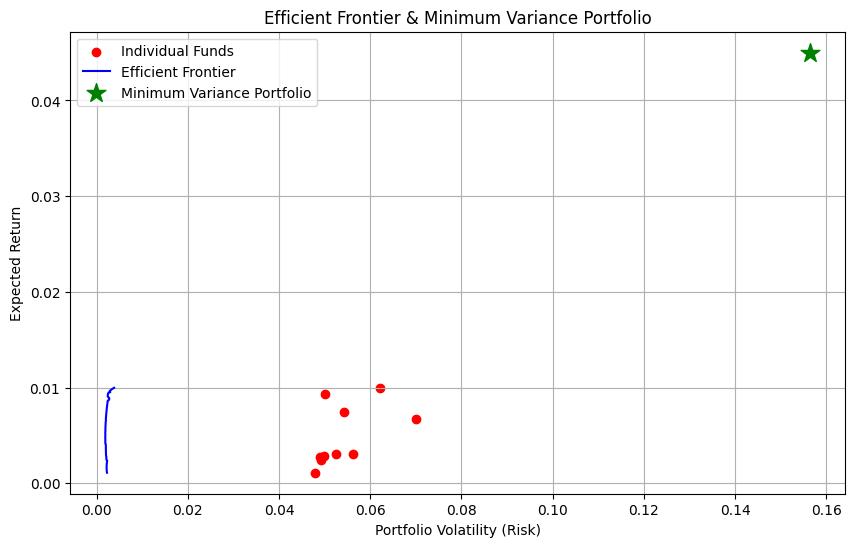


Minimum Variance Portfolio Weights:
     Fund        Weight
0  VWUSX  1.032393e-01
1  VTMGX  3.187554e-17
2  VEUSX  0.000000e+00
3  VFWAX  1.096444e-01
4  VDEQX  2.133552e-01
5  VTRIX  1.182054e-01
6  VQNPX  4.003418e-01
7  VSEQX  0.000000e+00
8  VEMAX  5.521382e-02
9  VTIAX  2.331035e-18


In [ ]:
import os
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt

data_path = "monthly_returns/"

files = [f for f in os.listdir(data_path) if f.endswith("_monthly_returns.csv")]

returns_data = []

for file in files:
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
    df = df.reset_index()
    df.columns = ["Date", "Returns"]
    if df.shape[1] < 2:
        print(f"Skipping {symbol}, insufficient data.")
        continue

    returns_data.append(df["Returns"])

# Merge all funds
returns_df = pd.concat(returns_data, axis=1)
returns_df.columns = symbols
returns_df.dropna(inplace=True)

mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()
num_assets = len(symbols)
bounds = [(0, 1)] * num_assets

def portfolio_variance(weights):
    return weights.T @ cov_matrix @ weights

def min_variance_portfolio():
    init_weights = np.ones(num_assets) / num_assets
    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}  # Sum of weights = 1
    
    result = sco.minimize(portfolio_variance, init_weights, method="SLSQP", bounds=bounds, constraints=constraints)
    return result.x

mvp_weights = min_variance_portfolio()

mvp_return = np.dot(mvp_weights, mean_returns) * 12
mvp_volatility = np.sqrt(mvp_weights.T @ cov_matrix @ mvp_weights) * np.sqrt(12)

# **Efficient Frontier Calculation**
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)
efficient_portfolios = []

for ret in target_returns:
    constraints_rf = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: np.dot(w, mean_returns) - ret}
    ]
    
    result = sco.minimize(portfolio_variance, np.ones(num_assets) / num_assets, method="SLSQP", bounds=bounds, constraints=constraints_rf)
    
    if result.success:
        efficient_portfolios.append((result.fun, ret))

efficient_portfolios = np.array(efficient_portfolios)

plt.figure(figsize=(10, 6))
plt.scatter(returns_df.std(), mean_returns, label="Individual Funds", color="red")
plt.plot(efficient_portfolios[:, 0], efficient_portfolios[:, 1], label="Efficient Frontier", color="blue")
plt.scatter(mvp_volatility, mvp_return, marker="*", color="green", s=200, label="Minimum Variance Portfolio")
plt.xlabel("Portfolio Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier & Minimum Variance Portfolio")
plt.legend()
plt.grid(True)
plt.show()

mvp_df = pd.DataFrame({"Fund": symbols, "Weight": mvp_weights})
print("\nMinimum Variance Portfolio Weights:\n", mvp_df)